In [1]:
## Import packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.72


In [3]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

tl289603	westus2	tl2896ws


In [4]:
from azureml.core import Experiment
experiment = Experiment(workspace=ws, name="TS-experiment")

In [5]:
# %%writefile $script_folder/train.py

from azureml.core import Dataset, Run

#run = Run.get_context()
#workspace = run.experiment.workspace

dataset_name = '10cities_eggfamily'

# Get a dataset by name
data = Dataset.get_by_name(workspace=ws, name=dataset_name)

# Load a TabularDataset into pandas DataFrame
data =data.to_pandas_dataframe()

In [6]:
## change data type of "date", (not necessary in Azure)
data['date'] = data['date'].astype('datetime64[ns]')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197557 entries, 0 to 197556
Data columns (total 17 columns):
id               197557 non-null int64
date             197557 non-null datetime64[ns]
store_nbr        197557 non-null int64
item_nbr         197557 non-null int64
unit_sales       197557 non-null float64
onpromotion      197557 non-null bool
city             197557 non-null object
state            197557 non-null object
store_type       197557 non-null object
store_cluster    197557 non-null int64
holiday_type     197557 non-null object
transferred      197557 non-null bool
transactions     197224 non-null float64
family           197557 non-null object
class            197557 non-null int64
perishable       197557 non-null int64
dcoilwtico       197557 non-null float64
dtypes: bool(2), datetime64[ns](1), float64(3), int64(6), object(5)
memory usage: 23.0+ MB


In [8]:
data.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,store_type,store_cluster,holiday_type,transferred,transactions,family,class,perishable,dcoilwtico
0,30,2013-01-01,25,158680,1.0,True,Salinas,Santa Elena,D,1,Holiday,False,770.0,EGGS,2502,1,93.14
1,56,2013-01-01,25,208384,3.0,True,Salinas,Santa Elena,D,1,Holiday,False,770.0,EGGS,2502,1,93.14
2,74,2013-01-01,25,227111,1.0,True,Salinas,Santa Elena,D,1,Holiday,False,770.0,EGGS,2502,1,93.14
3,81,2013-01-01,25,258268,6.0,True,Salinas,Santa Elena,D,1,Holiday,False,770.0,EGGS,2502,1,93.14
4,166,2013-01-01,25,376427,1.0,True,Salinas,Santa Elena,D,1,Holiday,False,770.0,EGGS,2502,1,93.14


In [9]:
total_sales = data.groupby('date').sum()
total_sales.head()

,id,store_nbr,item_nbr,unit_sales,onpromotion,store_cluster,transferred,transactions,class,perishable,dcoilwtico
date,,,,,,,,,,,
2013-01-01,2240,325,5466156,46.0,13.0,13,0.0,10010.0,32526,13,1210.82
2013-01-02,1784681,2180,41721238,522.0,81.0,489,81.0,102617.0,202672,81,7544.34
2013-01-03,4940236,2085,40908666,437.0,79.0,501,79.0,91744.0,197666,79,7344.63
2013-01-04,7550345,2030,38919266,348.0,73.0,417,73.0,77403.0,182656,73,6797.76
2013-01-05,11193183,2195,40238298,383.0,77.0,437,0.0,105159.0,192664,77,7170.24


In [10]:
total_sales = total_sales.drop(columns = ['id', 'store_nbr', 'item_nbr', 'onpromotion', 'store_cluster', 
                                          'transferred', 'transactions', 'class', 'perishable', 'dcoilwtico'])
total_sales.head()

,unit_sales
date,
2013-01-01,46.0
2013-01-02,522.0
2013-01-03,437.0
2013-01-04,348.0
2013-01-05,383.0


## Feature Selection

            unit_sales
date                  
2013-01-01        46.0
2013-01-02       522.0
2013-01-03       437.0
2013-01-04       348.0
2013-01-05       383.0


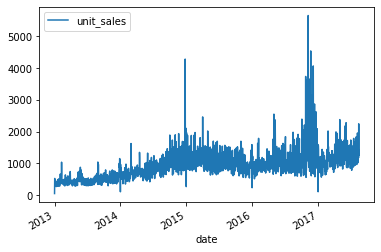

In [11]:
from matplotlib import pyplot
series = total_sales
# display first few rows
print(series.head(5))
# line plot of dataset
series.plot()
pyplot.show()

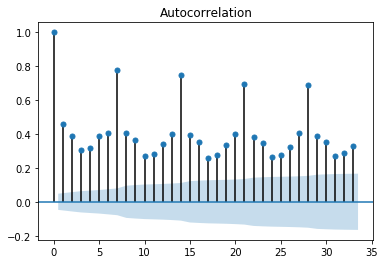

In [12]:
## Autocorrelation Plot
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(series)
pyplot.show()

Traditionally, time series features are selected based on their correlation with the output variable.

This is called autocorrelation and involves plotting autocorrelation plots, also called a correlogram. These show the correlation of each lagged observation and whether or not the correlation is statistically significant.

Running the code creates a correlogram, or Autocorrelation Function (ACF) plot, of the data.

The plot shows lag values along the x-axis and correlation on the y-axis between -1 and 1 for negatively and positively correlated lags respectively.

The dots above the blue area indicate statistical significance. The correlation of 1 for the lag value of 0 indicates 100% positive correlation of an observation with itself.

The plot shows significant lag values at 7, 14, 21, 28 days.

## ARIMA
#### To get to know ARIMA model, only use dates and sum of unit sales in the model
#### This would be the ARIMA time series model

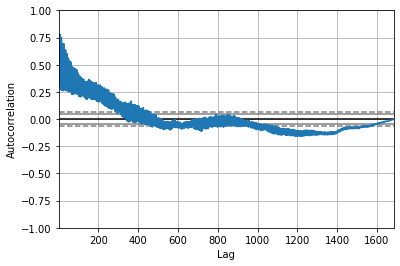

In [14]:
## autocorrelation plot of the time series

from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)
pyplot.show()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda/envs/azureml_py36/lib/python3.6/site

                             ARIMA Model Results                              
Dep. Variable:           D.unit_sales   No. Observations:                 1683
Model:                 ARIMA(7, 1, 0)   Log Likelihood              -11738.682
Method:                       css-mle   S.D. of innovations            258.368
Date:                Sat, 23 Nov 2019   AIC                          23495.365
Time:                        00:08:25   BIC                          23544.220
Sample:                             1   HQIC                         23513.460
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6402      1.295      0.494      0.621      -1.898       3.178
ar.L1.D.unit_sales    -0.7555      0.024    -31.270      0.000      -0.803      -0.708
ar.L2.D.unit_sales  

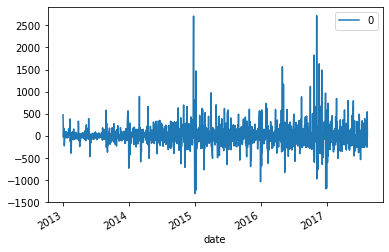

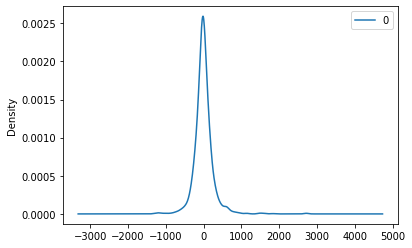

                 0
count  1683.000000
mean      0.381367
std     258.647344
min   -1305.165599
25%    -107.614359
50%     -12.935582
75%      90.973142
max    2721.307126


In [15]:
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(series, order=(7,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

1. model results including the coefficient values

2. Line plot of the residual errors;

3. Density plot of the residual error values;

4. The distribution of the residual errors is displayed.

The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the fut

predicted=1317.119995, expected=1911.000000
predicted=1057.284846, expected=798.000000
predicted=774.496307, expected=927.000000
predicted=724.095744, expected=705.000000
predicted=945.279332, expected=944.000000
predicted=966.937637, expected=909.000000
predicted=804.997357, expected=1111.000000
predicted=1565.654507, expected=1779.000000
predicted=998.124815, expected=799.000000
predicted=969.661564, expected=700.000000
predicted=719.768948, expected=749.000000
predicted=977.197160, expected=958.000000
predicted=984.356736, expected=1135.000000
predicted=1067.053322, expected=1054.000000
predicted=1432.913915, expected=1302.000000
predicted=867.839665, expected=875.000000
predicted=839.637035, expected=593.000000
predicted=767.658345, expected=868.000000
predicted=963.524595, expected=686.000000
predicted=1006.594587, expected=969.000000
predicted=942.677482, expected=1390.000000
predicted=1246.878160, expected=2391.000000
predicted=1321.495729, expected=1204.000000
predicted=898.723

predicted=967.444006, expected=805.000000
predicted=927.117398, expected=1020.000000
predicted=1317.912909, expected=1234.000000
predicted=941.902509, expected=951.000000
predicted=1280.079009, expected=1257.000000
predicted=1061.336019, expected=715.000000
predicted=933.481113, expected=923.000000
predicted=842.529769, expected=822.000000
predicted=1010.587257, expected=1060.000000
predicted=1170.512014, expected=1299.000000
predicted=990.827438, expected=1181.000000
predicted=1235.413452, expected=1604.000000
predicted=913.372161, expected=887.000000
predicted=1011.855276, expected=831.000000
predicted=866.244920, expected=972.000000
predicted=1104.769759, expected=926.000000
predicted=1220.407134, expected=1020.000000
predicted=1076.722517, expected=1003.000000
predicted=1396.717881, expected=1988.000000
predicted=1074.882193, expected=995.000000
predicted=944.327599, expected=1013.000000
predicted=1007.552880, expected=1281.000000
predicted=1083.511196, expected=1269.000000
predict

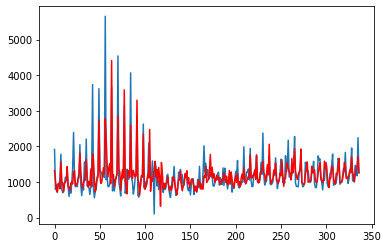

In [16]:
## rolling forecast with the ARIMA model in Python.

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

def parser(x):
	return datetime.strptime('210'+x, '%Y-%m')

series = total_sales
X = series.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(7,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Running the example prints the prediction and expected value each iteration.

We can also calculate a final mean squared error score (MSE) for the predictions, providing a point of comparison for other ARIMA configurations.

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale.

In [17]:
### Mean absolute percentage error (MAPE)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_true = test; y_pred = predictions

mean_absolute_percentage_error(y_true, y_pred)

21.716035952375982